# 6. 动能指标
*用TA_Lib画出动能指标*

## 目录

- 什么是动能指标?
- MOM/MACD/RSI/Stochastic是怎么计算的?
- 如何用图像展示动能指标？
- 如何用动能指标做策略?

## 什么是动能指标?
动能指标对价格的计算与物理学中对速度的计算相似，需要知道价格移动的距离、时间、移动的速度与加速度，这些变化都反映着市场价格在不同维度上的变化。动能指标的类型主要有两种，一种是Momentum 指标，它有中间轴，可以是0或100，上下没有界限；另一种是Oscillator 振荡器，它的取值在0至100之间。

## MOM/MACD/RSI/Stochastic是怎么计算的?

---

### 1. Momentum

$ROCR100=(Rrice_t/prevPrice_{t-10})*100$

---

### 2. MACD
$MACD = 26'day 'EMA - 12'day'EMA$
$MACD'signal=9'day 'EMA(MACD)$
$Hist = MACD - MACD' signal$

---

### 3. RSI

$RSI=100-\frac{100}{1+RS}$

$RS=\frac{\text{average of net UP closing changes for selected period of days}}{\text{average of net DOWN closing changes for selected period of days}}$

---

### 4. Stochastic
$Fast'K=\frac{C_t-L_n}{H_n-L_n}$

$Slow'K=MA(Fast'K,3)$

$Slow'D=MA(Slow'K,3)$

## 如何用图像展示动能指标？

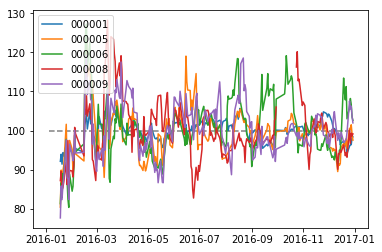

In [2]:
#Momentum 对比不同股票的动能
import talib as ta
import tushare as ts
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

symbol=['000001','000005','000006','000008','000009']
data_dict={}
for s in symbol:
    data = ts.get_k_data(s, start='2016-01-01', end='2016-12-31', ktype='D',autype='qfq')
    data.index = pd.to_datetime(data['date'], format='%Y-%m-%d')
    data['ROC'] = ta.abstract.ROCR100(data)
    data_dict[s]=data['ROC']
data = pd.DataFrame(data_dict)

plt.plot(data)
plt.hlines(100,data.index[0],data.index[-1] , linestyles='dashed', alpha=0.5)
plt.legend(data.columns, loc='upper left')
plt.show()

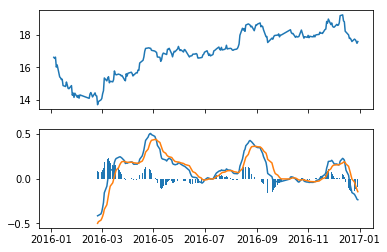

In [7]:
#MACD
data = ts.get_k_data('600036', start='2016-01-01', end='2016-12-31', ktype='D',autype='qfq')
data.index = pd.to_datetime(data['date'],format='%Y-%m-%d')
dc = np.array(data['close'])

data['MACD'], data['signal'], data['hist'] = ta.MACD(dc)

fig, (ax, ax1) = plt.subplots(2, 1, sharex=True)
ax.plot(data.index, data['close'])
ax1.plot(data.index, data['MACD'])
ax1.plot(data.index, data['signal'])
ax1.bar(data.index, data['hist'])
plt.show()

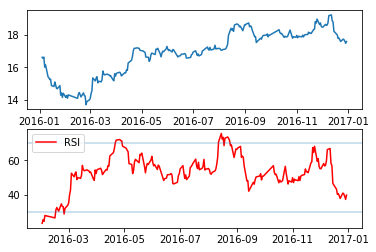

In [9]:
#RSI
data['RSI'] = ta.RSI(dc,20)

plt.subplot(2,1,1)
plt.plot(data['close'])
plt.subplot(2,1,2)
plt.plot(data['RSI'],'r', label='RSI')
plt.axhline(70,alpha=0.3)
plt.axhline(30,alpha=0.3)
plt.legend()
plt.show()

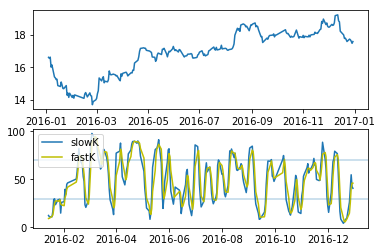

In [12]:
#Stochastic

kd = ta.abstract.STOCH(data, fastk_period=5, slowk_period=3, slowk_matype=0, slowd_period=3, slowd_matype=0)

plt.subplot(2,1,1)
plt.plot(data['close'])
plt.subplot(2,1,2)
plt.plot(kd['slowk'], label='slowK')
plt.plot(kd['slowd'],'y', label='fastK')
plt.axhline(70,alpha=0.3)
plt.axhline(30,alpha=0.3)
plt.legend(loc='upper left')
plt.show()

## 如何用动能指标做策略?

**1. 图表的领先形态（Charting Patterns-Leading ahead）:**
可以通过观察指标对价格做领先的形态或走势判断。

**2. 交叉信号（Cross Signals）：**
快线高于慢线金叉，看涨；快线低于慢线死叉，看跌。

**3. 柱的斜率（The slope of MACD-Histogram）：**
当前的柱比前一根高，看涨；当前的柱比前一根低，看跌。

**4. 超买超卖（Overbought/OverSold）：**
当振荡器高于上方的值如RSI(70)为超买，低于下方的值如RSI(30)为超卖，超卖买入，超买卖出。

**5. 背离（Divergence）：**
价格创新高，而指标没有创新高，顶背离，看跌。
价格创新低，而指标没有创新低，底背离，看涨。


## RSI均线判断背离方法: 
**底背离买入：**
$Close_t< MA(Close,20) \text{  and  } RSI > MA(RSI,20)$

**顶背离卖出：**
$Close_t> MA(Close,20) \text{  and  } RSI < MA(RSI,20)$

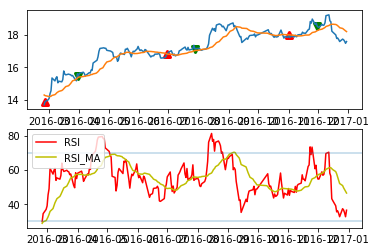

In [7]:
#RSI背离案例
import talib as ta
import tushare as ts
import pandas as pd
import matplotlib.pyplot as plt


data = ts.get_k_data('600036', start='2016-01-01', end='2016-12-31', ktype='D',autype='qfq')
data.index = pd.to_datetime(data['date'],format='%Y-%m-%d')


data['RSI'] = ta.abstract.RSI(data, 14)
data['RSI_MA'] = ta.abstract.MA(data, 20, price='RSI')
data['C_MA'] = ta.abstract.MA(data, 20, price='close')

buy_time = []
buy_price = []

sell_time= []
sell_price = []
data = data.dropna()
it = data.iterrows()
t0, p0 = next(it)
pos = 0
for t1, p1 in it:
    if pos==0 and p1.close < p1.C_MA and p1.RSI > p1.RSI_MA:
        buy_time.append(t1)
        buy_price.append(p1.close)
        pos=1
    elif pos==1 and p1.close > p1.C_MA and p1.RSI < p1.RSI_MA:
        sell_time.append(t1)
        sell_price.append(p1.close)
        pos=0
    t0, p0 = t1, p1

plt.subplot(2,1,1)
plt.plot(data['close'])
plt.plot(data['C_MA'])
plt.scatter(buy_time, buy_price, c='r', marker='^', linewidths=3)
plt.scatter(sell_time, sell_price, c='g', marker='v', linewidths=3)
plt.subplot(2,1,2)
plt.plot(data['RSI'],'r', label='RSI')
plt.plot(data['RSI_MA'],'y', label='RSI_MA')
plt.axhline(70,alpha=0.3)
plt.axhline(30,alpha=0.3)
plt.legend(loc='upper left')
plt.show()

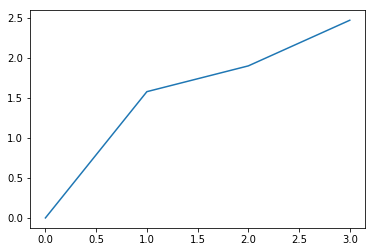

In [8]:
import numpy as np
money = np.array(sell_price) - np.array(buy_price)
money = list(money)
money.insert(0,0)
money = np.array(money)
capital = money.cumsum()
plt.plot(capital)
plt.show()

## 作业
根据RSI背离策略例子，写出其他的动能策略